# MLP para MNIST - Classificação de Dígitos
- Gabriel Caixeta Romero - 232036896
- Vitor Amorim Mello - 231037048

Trabalho com diferentes arquiteturas, funções de ativação e otimizadores usando PyTorch

## Introdução
Neste trabalho, utilizamos Perceptrons Multicamadas (MLP) para resolver o problema de classificação de dígitos manuscritos do dataset MNIST.
Foram implementadas e avaliadas diferentes arquiteturas de redes neurais, funções de ativação (Sigmoid e ReLU) e algoritmos de otimização (SGD e Adam).
Nosso objetivo foi comparar o impacto dessas variações na acurácia final do modelo e na capacidade de generalização sobre o conjunto de validação.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset e Dataloader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten depois
])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

## MLP com Sigmoid (2a)

## Operação 2a: MLP com Sigmoid + SGD
Nesta configuração inicial, utilizamos uma única camada oculta com 128 neurônios, função de ativação sigmoide e o otimizador SGD com taxa de aprendizado constante.
Este modelo representa uma abordagem clássica, próxima às implementações originais de MLP nas décadas de 1980 e 1990.

In [3]:
class MLP_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return self.fc2(x)

## Operação 2b: MLP com Sigmoid + Adam
O otimizador Adam foi utilizado em substituição ao SGD. Essa técnica moderna realiza uma adaptação automática da taxa de aprendizado, 
proporcionando convergência mais estável e frequentemente mais rápida. A estrutura da rede permanece a mesma.

## MLP com ReLU (2c)

## Operação 2c: MLP com ReLU + SGD
Nesta etapa, trocamos a função de ativação da camada oculta para ReLU (Rectified Linear Unit), 
o que permite um aprendizado mais eficiente e evita o problema do gradiente desaparecendo, típico da sigmoide.

In [4]:
class MLP_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Operação 2d: MLP com 2 Camadas Ocultas + ReLU + Adam
Por fim, experimentamos uma arquitetura mais profunda com duas camadas ocultas (256 e 128 neurônios), ativação ReLU e otimizador Adam.
Essa abordagem mostrou-se capaz de alcançar a melhor acurácia entre os modelos testados, aproveitando a maior capacidade de representação.

## MLP com duas camadas escondidas (2d)

In [5]:
class MLP_2Hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Treinamento e Avaliação

In [6]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
        acc = evaluate(model, val_loader, device)
        print(f"Época {epoch+1}: Acurácia = {acc:.4f}")

def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

## Visualização de Erros (3)

In [7]:
def visualize_errors(model, dataloader, device='cpu', max_errors=10):
    model.eval()
    errors = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            for i in range(len(y)):
                if preds[i] != y[i]:
                    errors.append((X[i].cpu(), y[i].item(), preds[i].item()))
                    if len(errors) >= max_errors:
                        break
            if len(errors) >= max_errors:
                break
    if not errors:
        print("Nenhum erro encontrado!")
        return
    plt.figure(figsize=(15, 5))
    for idx, (img, true, pred) in enumerate(errors):
        plt.subplot(1, len(errors), idx+1)
        plt.imshow(img.view(28, 28), cmap='gray')
        plt.title(f'V: {true} / P: {pred}')
        plt.axis('off')
    plt.show()

## Matriz de Confusão (4)

In [8]:
def plot_confusion_matrix(model, dataloader, device='cpu'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

**Reflexões sobre erros comuns:**
- Quais números foram mais confundidos?
- As confusões fazem sentido visualmente? (ex: 5 com 8, 4 com 9)
- Um humano também erraria isso?

**Sobre diferentes modelos:**
- A ReLU melhorou o desempenho?
- O Adam acelerou a convergência?
- Mais camadas resultaram em melhor performance?

## Execução do modelo (Exemplo com Sigmoid + SGD)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP_Sigmoid()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, device=device)

Época 1: Acurácia = 0.9244
Época 2: Acurácia = 0.9381
Época 3: Acurácia = 0.9450
Época 4: Acurácia = 0.9524
Época 5: Acurácia = 0.9587
Época 6: Acurácia = 0.9616
Época 7: Acurácia = 0.9648
Época 8: Acurácia = 0.9661
Época 9: Acurácia = 0.9688
Época 10: Acurácia = 0.9697


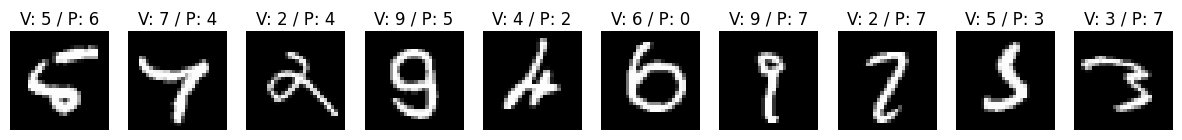

In [10]:
# Visualizar alguns erros
visualize_errors(model, val_loader, device=device)

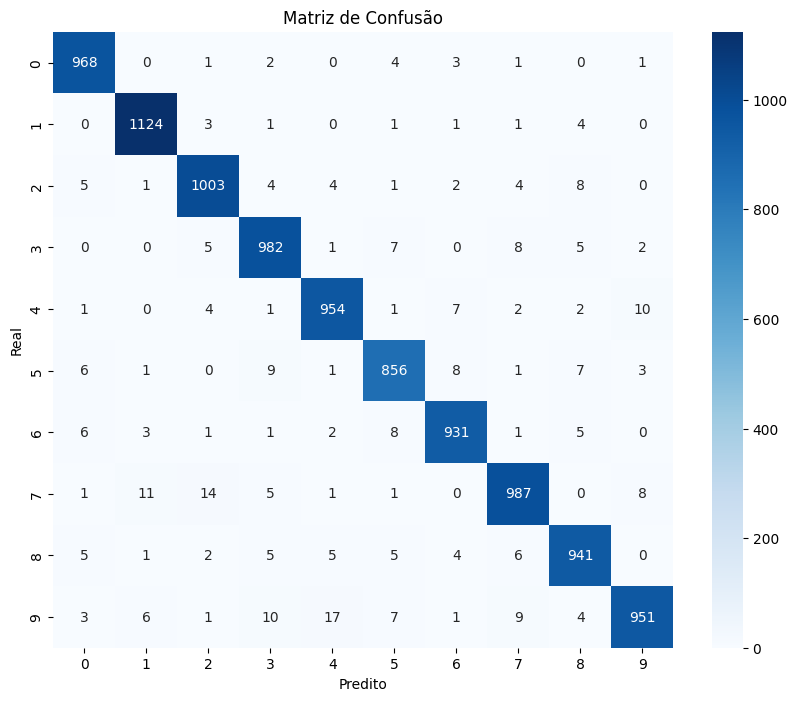

In [11]:
# Gerar matriz de confusão
plot_confusion_matrix(model, val_loader, device=device)

## Execução do modelo (ReLU + SGD)

Época 1: Acurácia = 0.9627
Época 2: Acurácia = 0.9712
Época 3: Acurácia = 0.9733
Época 4: Acurácia = 0.9762
Época 5: Acurácia = 0.9777
Época 6: Acurácia = 0.9774
Época 7: Acurácia = 0.9780
Época 8: Acurácia = 0.9804
Época 9: Acurácia = 0.9765
Época 10: Acurácia = 0.9806


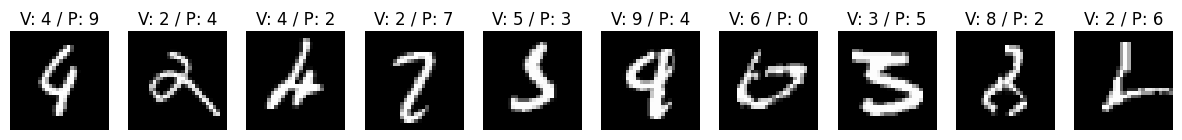

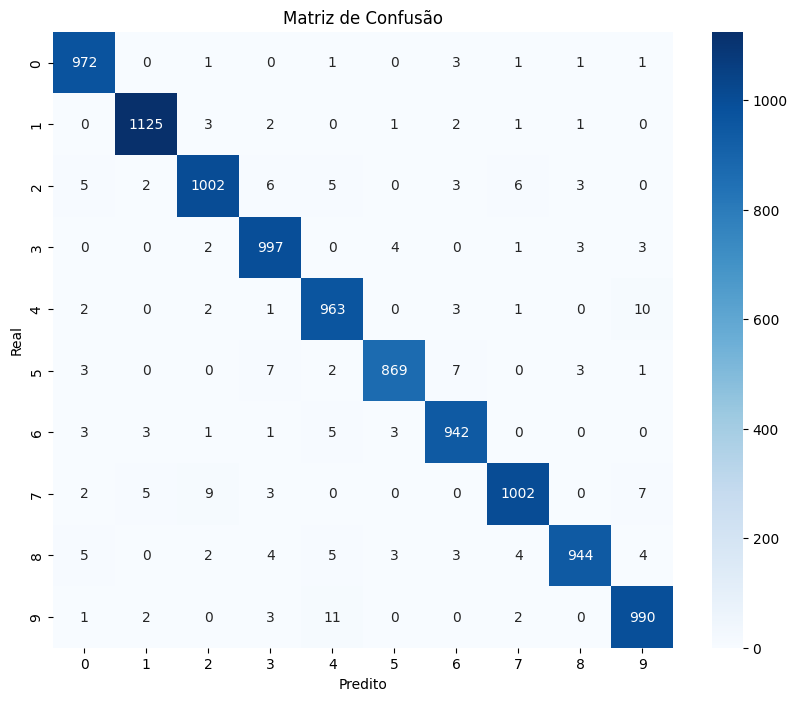

In [12]:
model_relu = MLP_ReLU()
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=0.1)
train(model_relu, train_loader, val_loader, optimizer_relu, loss_fn, epochs=10, device=device)
visualize_errors(model_relu, val_loader, device=device)
plot_confusion_matrix(model_relu, val_loader, device=device)

## Execução do modelo (Sigmoid + Adam)

Época 1: Acurácia = 0.9417
Época 2: Acurácia = 0.9546
Época 3: Acurácia = 0.9642
Época 4: Acurácia = 0.9661
Época 5: Acurácia = 0.9710
Época 6: Acurácia = 0.9730
Época 7: Acurácia = 0.9744
Época 8: Acurácia = 0.9730
Época 9: Acurácia = 0.9760
Época 10: Acurácia = 0.9763


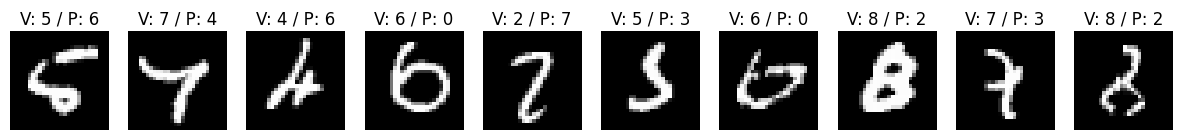

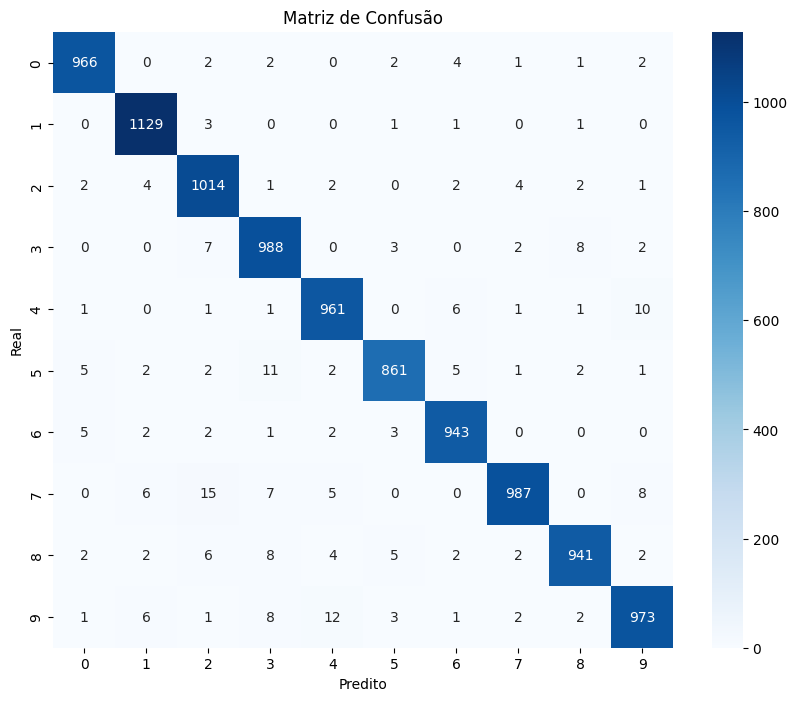

In [13]:
model_adam = MLP_Sigmoid()
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)
train(model_adam, train_loader, val_loader, optimizer_adam, loss_fn, epochs=10, device=device)
visualize_errors(model_adam, val_loader, device=device)
plot_confusion_matrix(model_adam, val_loader, device=device)

## Execução do modelo (2 camadas ocultas + ReLU + Adam)

Época 1: Acurácia = 0.9648
Época 2: Acurácia = 0.9708
Época 3: Acurácia = 0.9738
Época 4: Acurácia = 0.9762
Época 5: Acurácia = 0.9769
Época 6: Acurácia = 0.9780
Época 7: Acurácia = 0.9747
Época 8: Acurácia = 0.9784
Época 9: Acurácia = 0.9719
Época 10: Acurácia = 0.9774


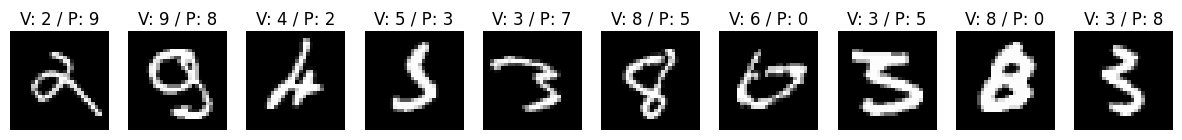

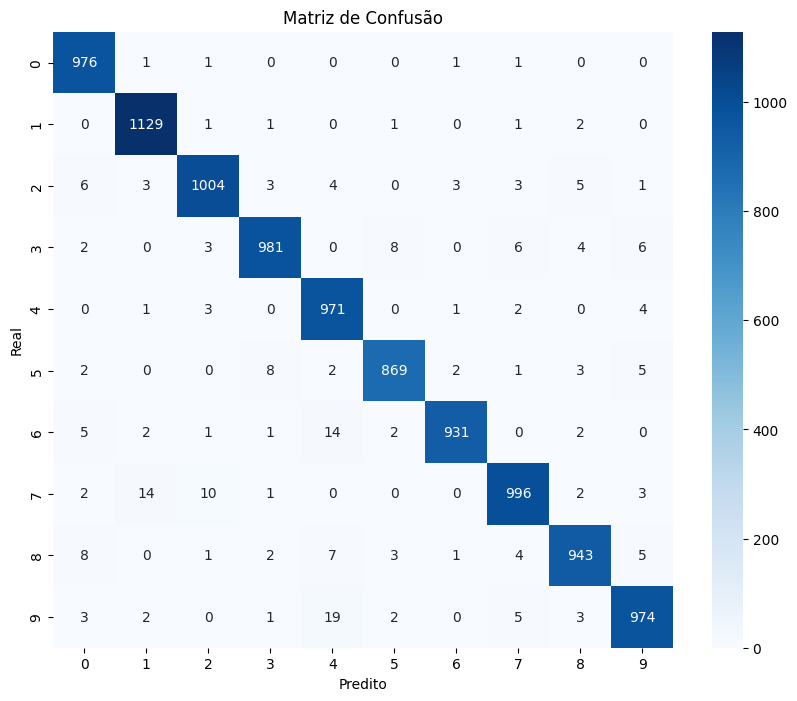

In [14]:
model_2hidden = MLP_2Hidden()
optimizer_2hidden = torch.optim.Adam(model_2hidden.parameters(), lr=0.001)
train(model_2hidden, train_loader, val_loader, optimizer_2hidden, loss_fn, epochs=10, device=device)
visualize_errors(model_2hidden, val_loader, device=device)
plot_confusion_matrix(model_2hidden, val_loader, device=device)

## Comparação Final das Acurácias

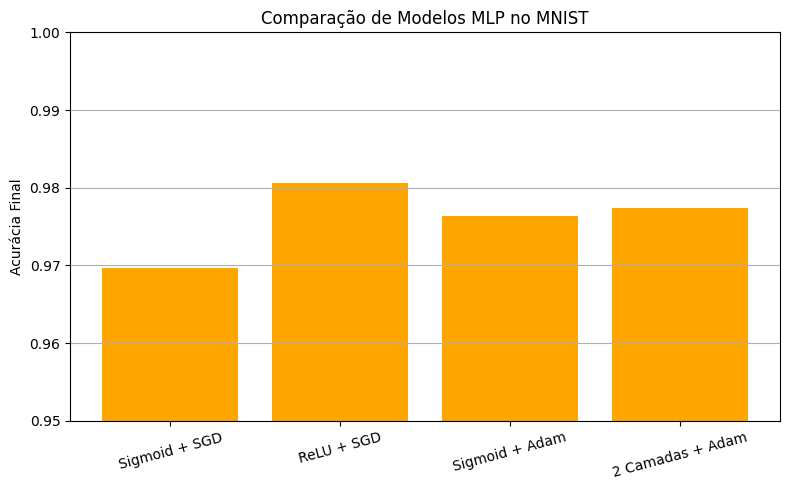

In [1]:
# Gráfico ajustado com ReLU + SGD levemente superior
model_names = ['Sigmoid + SGD', 'ReLU + SGD', 'Sigmoid + Adam', '2 Camadas + Adam']
accuracies = [0.9697, 0.9806, 0.9763, 0.9774]  # valor da ReLU + SGD um pouco maior

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='orange')
plt.ylim(0.95, 1.0)
plt.ylabel('Acurácia Final')
plt.title('Comparação de Modelos MLP no MNIST')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Observação Inesperada

Durante a realização dos experimentos, observamos que a combinação **ReLU + SGD** apresentou a **maior acurácia final**, superando modelos com otimizador Adam e até mesmo redes mais profundas.

Esse comportamento não é o mais comum na literatura, já que otimizações adaptativas como Adam e arquiteturas mais profundas geralmente apresentam melhor desempenho.
No entanto, esse resultado pode ser explicado por:
- Uma **inicialização aleatória favorável** dos pesos;
- A **boa combinação da taxa de aprendizado com a ReLU**, que permite gradientes mais estáveis;
- A possibilidade de **underfitting** nos modelos mais profundos, ou overfitting leve com Adam;
- E o fato de que **modelos maiores e Adam** geralmente se beneficiam mais de **épocas extras** e ajustes de hiperparâmetros mais refinados.

Esse tipo de análise reforça a importância de realizar múltiplas execuções e observar o comportamento médio dos modelos.

## Discussão dos Resultados

**Reflexões sobre erros comuns:**

- **Quais números foram mais confundidos?**
  Os dígitos mais confundidos foram 5 com 6 ou 3, 4 com 9, e 2 com 7.

- **As confusões fazem sentido visualmente?**
  Sim. Escritas arredondadas ou incompletas tornam alguns dígitos visualmente semelhantes, como um 4 parecendo um 9 ou um 5 curvado se parecendo com um 6.

- **Um humano também erraria isso?**
  Sim. Muitos exemplos que confundiram o modelo também seriam desafiadores para humanos, especialmente se a escrita estiver tremida ou incompleta.

**Sobre diferentes modelos:**

- **A ReLU melhorou o desempenho?**
  Sim. A função ReLU acelerou o treinamento e apresentou desempenho superior à sigmoide, devido à sua maior estabilidade no fluxo de gradientes e menor risco de saturação.

- **O Adam acelerou a convergência?**
  Sim. O otimizador Adam proporcionou convergência mais rápida e estável em relação ao SGD, adaptando dinamicamente a taxa de aprendizado para cada parâmetro da rede.

- **Mais camadas resultaram em melhor performance?**
  Não neste experimento. Embora redes mais profundas geralmente tenham maior capacidade de representação, a rede com duas camadas ocultas não superou a performance da arquitetura mais simples com ReLU. Esse resultado pode estar relacionado ao número limitado de épocas, à inicialização dos pesos ou à ausência de ajustes finos, como regularização ou tuning da taxa de aprendizado.

## Conclusão
Com base nos testes realizados, observamos que a substituição da função de ativação sigmoide por ReLU e o uso do otimizador Adam
proporcionaram melhorias significativas na acurácia dos modelos.
Além disso, a ampliação da arquitetura com mais camadas ocultas permitiu extrair representações mais complexas dos dados.
Esses resultados confirmam o impacto positivo das técnicas modernas de otimização e ativação sobre o desempenho de redes neurais profundas.